2015

In [ ]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import bs4
import requests
nlp = spacy.load('en_core_web_sm')
from spacy.matcher import Matcher 
from spacy.tokens import Span 
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

Import 2015 files
Text file to extract most frequent entities 
CSV file to construct the knowledge graph

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving document_2015_foreward.txt to document_2015_foreward.txt


In [ ]:
# Load article
doc_2015 = open('document_2015_foreward.txt', 'rb').read().decode('ISO-8859-1')
# Process
article_2015 = nlp(doc_2015)
# Print entities
len(article_2015.ents)
# 63 entities

63

In [ ]:
# Find unique entities
# Find unique labels
labels = [x.label_ for x in article_2015.ents]
Counter(labels)

Counter({'CARDINAL': 9,
         'DATE': 13,
         'GPE': 7,
         'LOC': 5,
         'MONEY': 2,
         'NORP': 2,
         'ORDINAL': 5,
         'ORG': 17,
         'PERCENT': 2,
         'PERSON': 1})

Most freqently occuring entities are:
ORG at 17, DATE at 13, CARDINAL at 9, GPE at 7

Different from 2010 document. Event does not appear

Find the most frequently occuring:

ORG

In [ ]:
Counter([(x, x, x.label_) for x in nlp(doc_2015).ents
                                 if x.label_ == 'ORG']).most_common(10)

[((National Security Strategy, National Security Strategy, 'ORG'), 1),
 ((NATO, NATO, 'ORG'), 1),
 ((UN, UN, 'ORG'), 1),
 ((National Security Strategy, National Security Strategy, 'ORG'), 1),
 ((Parliament, Parliament, 'ORG'), 1),
 ((the National Security Council, the National Security Council, 'ORG'), 1),
 ((BritainÕs Armed Forces, BritainÕs Armed Forces, 'ORG'), 1),
 ((Armed Forces, Armed Forces, 'ORG'), 1),
 ((F35, F35, 'ORG'), 1),
 ((Maritime Patrol Aircraft, Maritime Patrol Aircraft, 'ORG'), 1)]

DATE

In [ ]:
Counter([(x, x, x.label_) for x in nlp(doc_2015).ents
                                 if x.label_ == 'DATE']).most_common(10)

[((the last five years, the last five years, 'DATE'), 1),
 ((2010, 2010, 'DATE'), 1),
 ((that year, that year, 'DATE'), 1),
 ((the last two years, the last two years, 'DATE'), 1),
 ((five years ago, five years ago, 'DATE'), 1),
 ((today, today, 'DATE'), 1),
 ((the coming five years, the coming five years, 'DATE'), 1),
 ((Today, Today, 'DATE'), 1),
 ((the last five years, the last five years, 'DATE'), 1),
 ((2025, 2025, 'DATE'), 1)]

CARDINAL

In [ ]:
Counter([(x, x, x.label_) for x in nlp(doc_2015).ents
                                 if x.label_ == 'CARDINAL']).most_common(10)

[((5 million, 5 million, 'CARDINAL'), 1),
 ((two, two, 'CARDINAL'), 1),
 ((nine, nine, 'CARDINAL'), 1),
 ((two, two, 'CARDINAL'), 1),
 ((up to 5,000, up to 5,000, 'CARDINAL'), 1),
 ((around 50,000, around 50,000, 'CARDINAL'), 1),
 ((30,000, 30,000, 'CARDINAL'), 1),
 ((four, four, 'CARDINAL'), 1),
 ((1,900, 1,900, 'CARDINAL'), 1)]

GPE

In [ ]:
Counter([(x, x.label_) for x in nlp(doc_2015).ents
                                 if x.label_ == 'GPE']).most_common(10)

[((Britain, 'GPE'), 1),
 ((Ukraine, 'GPE'), 1),
 ((the United Kingdom, 'GPE'), 1),
 ((United Kingdom, 'GPE'), 1),
 ((Scotland, 'GPE'), 1),
 ((North Africa, 'GPE'), 1),
 ((Britain, 'GPE'), 1)]

Have a look at all entities for interest

In [ ]:
Counter([(x, x.label_) for x in nlp(doc_2015).ents
                                 if x.label_ == 'LOC']).most_common(10)


[((the Middle East, 'LOC'), 1),
 ((Typhoon, 'LOC'), 1),
 ((the Middle East, 'LOC'), 1),
 ((South Asia, 'LOC'), 1),
 ((Europe, 'LOC'), 1)]

In [ ]:
Counter([(x, x.label_) for x in nlp(doc_2015).ents
                                 if x.label_ == 'MONEY']).most_common(10)

[((every penny, 'MONEY'), 1), ((£2.5 billion, 'MONEY'), 1)]

Create knoweldge graph
Using the text data reformulated into sentences as a CSV

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving text_2015.csv to text_2015.csv


Read in text file

In [ ]:
text_2015 = pd.read_csv("text_2015.csv")

Extract sentences which contain keywords identified using NER: Events, Countries, Organisations 

Starting implementation for all terms

In [ ]:
keywords_2015_all = ['National Security Strategy', 'NATO', 'UN', 'National Security Strategy', 'Parliament', 'Al Qaeda','the National Security Council', 
            'BritainÕs Armed Forces', 'Armed Forces', 'Maritime Patrol Aircraft', 'Britain','Ukraine', 'United Kingdom', 'Scotland', 'North Africa']


In [ ]:
searched_keywords_2015_all = '|'.join(keywords_2015_all)

In [ ]:
text_2015_filter_all = text_2015[text_2015["sentence"].str.contains(searched_keywords_2015_all)]

In [ ]:
# text_2015_filter_all
# 1024 rows

Run through the knowledge graph construction

Define function to extract entities

In [ ]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

Use this function to extract these entity pairs for all the sentences in our data

In [ ]:
entity_pairs = []

for i in tqdm(text_2015_filter_all["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 1024/1024 [00:11<00:00, 87.93it/s]


The list entity_pairs contains all the subject-object pairs

In [ ]:
entity_pairs[10:20]

[['We', 'maritime Maritime Patrol search'],
 ['', 'terrorism Middle East'],
 ['overseas  which', 'greater  world'],
 ['common  that', 'change'],
 ['Armed Forces', 'security  line'],
 ['they', 'country'],
 ['National Security economy', 'National Security Strategy'],
 ['economic  Britain', 'two  years'],
 ['threat cyber world', 'threat cyber pandemics'],
 ['today  which', '2 UN spending']]

Capture predicates using spaCy’s rule-based matching:

In [ ]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern], on_match=None) 

  matches = matcher(doc)
  k = len(matches) -1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [ ]:
relations = [get_relation(i) for i in tqdm(text_2015_filter_all['sentence'])]
tqdm._instances.clear()

100%|██████████| 1024/1024 [00:13<00:00, 75.09it/s]


Most frequent relations or predicates that we have just extracted

In [ ]:
pd.Series(relations).value_counts()[:50]

is              192
become           64
sets             64
presents         64
are              64
continue         64
reconfigured     64
ensure           64
buy              64
billion          64
means            64
depends          64
put              64
back             64
dtype: int64

Create a knowledge graph from the extracted entities (subject-object pairs) and the predicates (relation between entities).

In [ ]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [ ]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

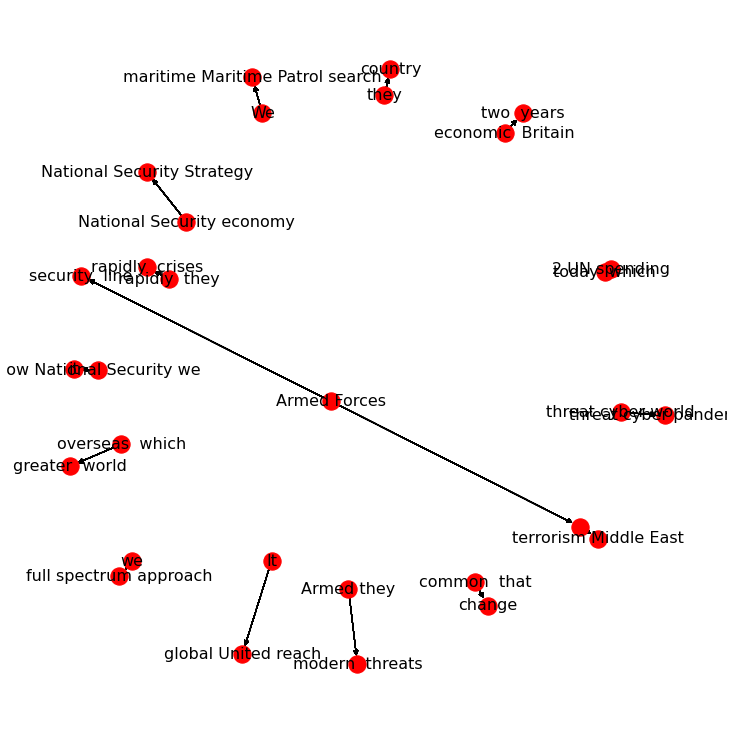

In [ ]:
plt.figure(figsize=(10,10))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='red', edge_cmap=plt.cm.Blues, pos = pos, font_size= 16)
plt.show()

Creating subgraphs to segement on countries, events, organisations

Countries

In [ ]:
# Segement data
keywords_2015_GPE = ['Britain', 'Ukraine', 'United Kingdom', 'Scotland', 'North Africa']
searched_keywords_2015_GPE = '|'.join(keywords_2015_GPE)
# Filter
text_2015_filter_GPE = text_2015[text_2015["sentence"].str.contains(searched_keywords_2015_GPE)]
text_2015_filter_GPE
# 576 sentences

In [ ]:
# Get entity pairs
entity_pairs_2015_GPE = []

for i in tqdm(text_2015_filter_GPE["sentence"]):
  entity_pairs_2015_GPE.append(get_entities(i))

# Get relations
relations_2015_GPE = [get_relation(i) for i in tqdm(text_2015_filter_GPE['sentence'])]
tqdm._instances.clear()
# Subject
source_2015_GPE = [i[0] for i in entity_pairs_2015_GPE]
# Object
target_2015_GPE = [i[1] for i in entity_pairs_2015_GPE]
# Create df
kg_df_2015_GPE = pd.DataFrame({'source':source_2015_GPE, 'target':target_2015_GPE, 'edge':relations_2015_GPE})
# Create graph
G_2015_GPE =nx.from_pandas_edgelist(kg_df_2015_GPE, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
# Graph
pos = nx.spring_layout(G_2015_GPE)
nx.draw(G_2015_GPE, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Organisations

In [ ]:
# Keywords
keywords_2015_ORG = ['National Security Strategy','NATO','UN', 'the European Union', 'NATO', 'National Security Strategy','Parliament', 
                     'the National Security Council', 'Armed Forces', 'Maritime Patrol Aircraft']
searched_keywords_2015_ORG = '|'.join(keywords_2015_ORG)
# Filter
text_2015_filter_ORG = text_2015[text_2015["sentence"].str.contains(searched_keywords_2015_ORG)]
text_2015_filter_ORG
# 640 rows

100%|██████████| 640/640 [00:07<00:00, 84.95it/s]


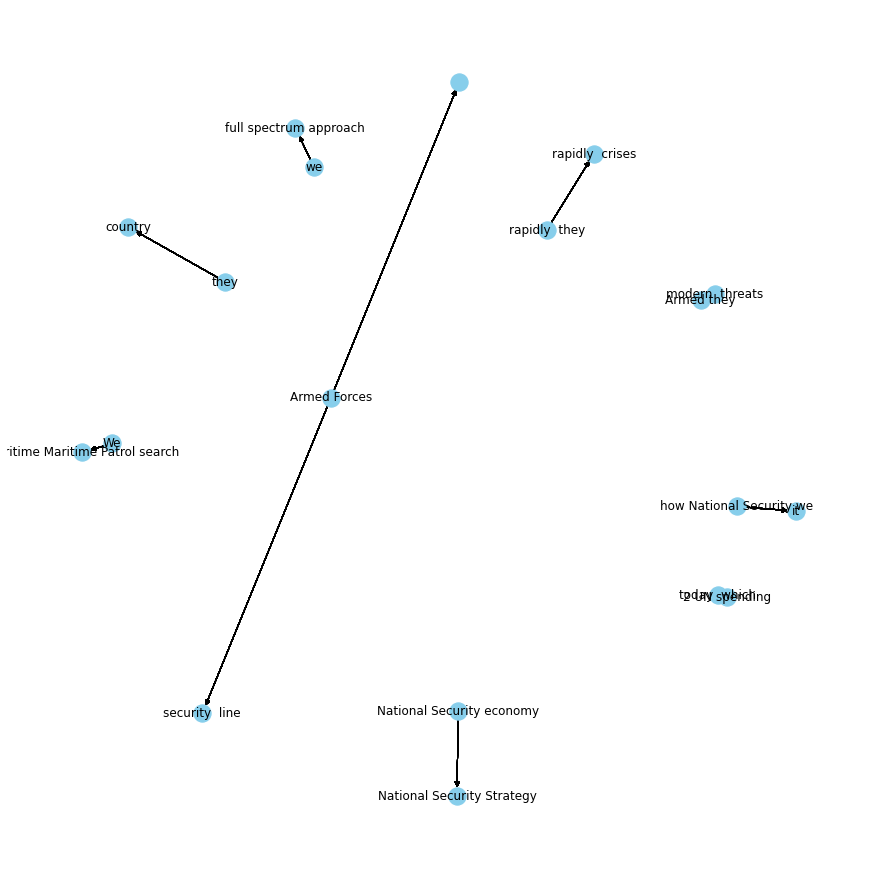

In [ ]:
# Get entity pairs
entity_pairs_2015_ORG = []

for i in tqdm(text_2015_filter_ORG["sentence"]):
  entity_pairs_2015_ORG.append(get_entities(i))

#entity_pairs_2010_ORG[10:20]
# Get relations
relations_2015_ORG = [get_relation(i) for i in tqdm(text_2015_filter_ORG['sentence'])]
tqdm._instances.clear()
# Subject
source_2015_ORG = [i[0] for i in entity_pairs_2015_ORG]
# Object
target_2015_ORG = [i[1] for i in entity_pairs_2015_ORG]
# Create df
kg_df_2015_ORG = pd.DataFrame({'source':source_2015_ORG, 'target':target_2015_ORG, 'edge':relations_2015_ORG})
# Create graph
G_2015_ORG =nx.from_pandas_edgelist(kg_df_2015_ORG, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
# Graph
pos = nx.spring_layout(G_2015_ORG)
nx.draw(G_2015_ORG, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Date

In [ ]:
# Keywords
keywords_2015_DATE = ['the last five years', '2010', 'that year', 'the last two years', 'five years ago', 'today', 'the coming five years', 'the last five years']
searched_keywords_2015_DATE = '|'.join(keywords_2015_DATE)
# Filter
text_2015_filter_DATE = text_2015[text_2015["sentence"].str.contains(searched_keywords_2015_DATE)]
text_2015_filter_DATE
# 512

100%|██████████| 512/512 [00:05<00:00, 87.92it/s]


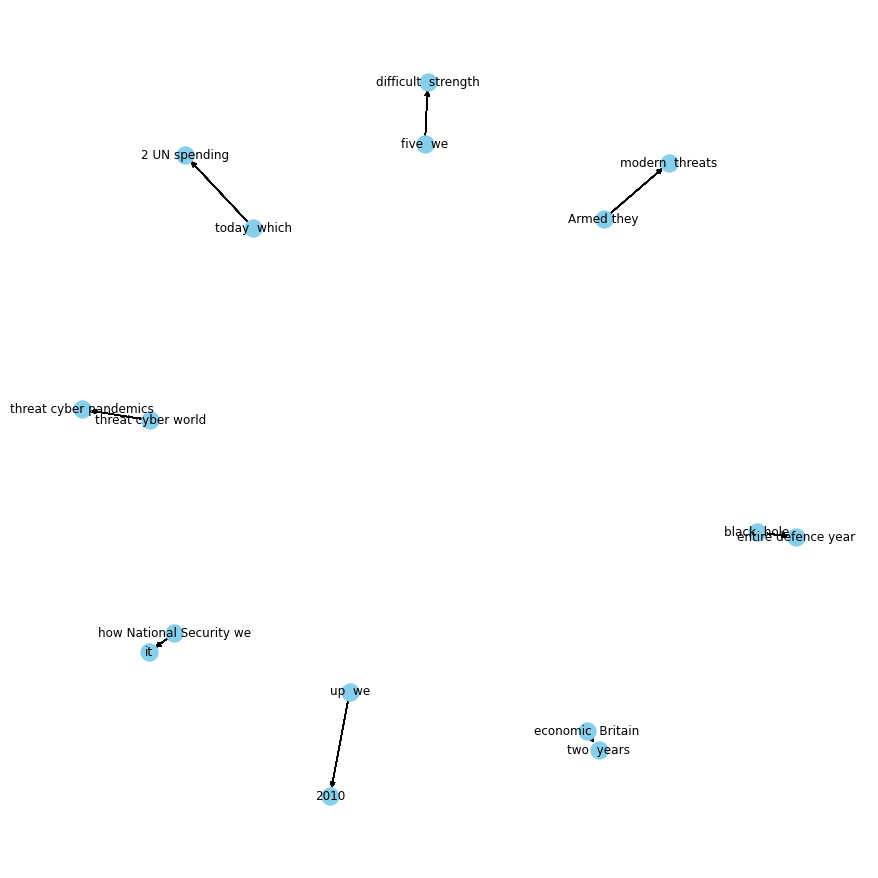

In [ ]:
# Get entity pairs
entity_pairs_2015_DATE = []

for i in tqdm(text_2015_filter_DATE["sentence"]):
  entity_pairs_2015_DATE.append(get_entities(i))

#entity_pairs_2010_ORG[10:20]
# Get relations
relations_2015_DATE = [get_relation(i) for i in tqdm(text_2015_filter_DATE['sentence'])]
tqdm._instances.clear()
# Subject
source_2015_DATE = [i[0] for i in entity_pairs_2015_DATE]
# Object
target_2015_DATE = [i[1] for i in entity_pairs_2015_DATE]
# Create df
kg_df_2015_DATE = pd.DataFrame({'source':source_2015_DATE, 'target':target_2015_DATE, 'edge':relations_2015_DATE})
# Create graph
G_2015_DATE =nx.from_pandas_edgelist(kg_df_2015_DATE, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
# Graph
pos = nx.spring_layout(G_2015_DATE)
nx.draw(G_2015_DATE, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()